In [1]:
from graph import *
from models import *
from metrics import *

import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import plotly.graph_objects as go

In [2]:
# load data from the spreadsheet which defines the structure of the workflow,
# as well as the parameters for data rates, efficiency, data reduction, and classifier performance
# ...these are taken from predictions for the Run-5 CMS
run5_system = dataframes_from_spreadsheet("cms_system_200.xlsx")

In [3]:
run5_system.detectors

,Category,Detector,Data (bytes),Sample Rate,Compression,Link Efficiency (J/bit),Op Efficiency (J/op),PU 200
0,Tracking,Inner Tracker,1440000,40000000,0,2.220000e-11,0,1.440
1,Tracking,Outer Tracker PS,720000,40000000,0,2.220000e-11,0,0.720
2,Tracking,Outer Tracker 2S,430000,40000000,0,2.220000e-11,0,0.430
3,Tracking,Track Finder TPG,10000,40000000,0,2.220000e-11,0,0.010
4,Timing,MIP Timing BTL,240000,40000000,0,2.220000e-11,0,0.240
5,Timing,MIP Timing ETL,440000,40000000,0,2.220000e-11,0,0.440
6,Calorimetry,ECAL Barrel,600000,40000000,0,2.220000e-11,0,0.600
7,Calorimetry,HCAL Barrel,240000,40000000,0,2.220000e-11,0,0.240
8,Calorimetry,HCAL HO,30000,40000000,0,2.220000e-11,0,0.030
9,Calorimetry,HCAL HF,60000,40000000,0,2.220000e-11,0,0.060


In [4]:
run5_system.triggers

,Name,Output,Data (bytes),Reduction Ratio,Skill mean,Skill variance,Link Efficiency (J/bit),Op Efficiency (J/op),Compression
0,Tracking,Intermediate,0,1.0,0,0,2.500000e-11,0.000,0
1,Timing,Intermediate,0,1.0,0,0,2.500000e-11,0.000,0
2,Calorimetry,Intermediate,0,1.0,0,0,2.500000e-11,0.000,0
3,Muon,Intermediate,0,1.0,0,0,2.500000e-11,0.000,0
4,Intermediate,Global,260000,53.3,3,1,2.500000e-11,0.003,0
5,Global,Disk,0,100.0,4,1,2.500000e-11,16.000,0
6,Disk,NaN,0,1.0,0,0,2.500000e-11,0.000,0


In [5]:
#calculate the total reduction to keep this constant across experiments
overall_reduction = run5_system.triggers.iloc[4]["Reduction Ratio"] * run5_system.triggers.iloc[5]["Reduction Ratio"]

In [6]:
#import the data predicting wall time scaling by pileup
scaling = pd.read_excel("wall time scaling.xlsx", sheet_name="Data")
#fit a polynomial to this data for CPU and GPU runtimes
fit_poly = lambda x, k3, k2, k1: k3 * x ** 3 + k2 * x ** 2 + k1 * x
k, cv = curve_fit(fit_poly, scaling["Size"], scaling["Wall Time"])
k_gpu, cv_gpu = curve_fit(fit_poly, scaling["Size"], scaling["Wall Time GPU"])

In [7]:
#define a dictionary with functions defining the scaling of trigger runtimes with incoming data
funcs = {"Global": lambda x: fit_poly(x, *k), "Intermediate": lambda x: x / 2.0e6}
funcs_gpu = {"Global": lambda x: fit_poly(x, *k_gpu), "Intermediate": lambda x: x / 2.0e6}

In [8]:
"""
Vary the accept rate of the level 1 trigger and inspect its impact on performance and resources required
"""
def vary_l1t_accept(system: System, functions, reduction: float):
    t = system.triggers.copy()
    #intermediate reduction stage
    t.at[4, "Reduction Ratio"] = reduction
    #global reduction stage
    t.at[5, "Reduction Ratio"] = overall_reduction / reduction
    g = construct_graph(system.detectors, t, system.globals, functions)

    power = g.graph["op power"] + g.graph["link power"]
    confusion = g.graph["performance"]

    return confusion, power, g

In [9]:
#the planned Run-5 L1 accept
ex = vary_l1t_accept(run5_system, funcs, 53.3)

In [10]:
list(ex[2].nodes)

['Inner Tracker',
 'Outer Tracker PS',
 'Outer Tracker 2S',
 'Track Finder TPG',
 'MIP Timing BTL',
 'MIP Timing ETL',
 'ECAL Barrel',
 'HCAL Barrel',
 'HCAL HO',
 'HCAL HF',
 'HGCAL',
 'HGCAL TPG Stage1',
 'HGCAL TPG Stage2',
 'Muon DT',
 'Muon CSC',
 'Muon GEM GE1',
 'Muon GEM GE2',
 'Muon GEM ME0',
 'Muon RPC',
 'Tracking',
 'Timing',
 'Calorimetry',
 'Muon',
 'Intermediate',
 'Global',
 'Disk']

In [11]:
run5_graph = ex[2]

In [12]:
run5_graph.nodes["Global"]["power"] / 1e6 / 6.8

49.22659677724248

In [13]:
ex[2].graph['op power'] / density_scale_model(ex[2].graph["globals"]["Year"][0]) / 1e6

51.57977090119172

In [14]:
#its predicted confusion matrix for the workflow
ex[0]

array([[3.99904638e+07, 2.03146077e+03],
       [2.03146035e+03, 5.47322966e+03]])

In [15]:
#and total required power (MW) using 2024's technology
ex[1] / 1e6

335.3709594309368

In [16]:
#vary this accept rate from today's rate to beyond the planned Run-5 level
l1t_reductions = np.linspace(400, 20.0, 101)

In [17]:
run5_res = [vary_l1t_accept(run5_system, funcs, r) for r in l1t_reductions]

In [18]:
def extract_metrics(results):
    all_confusion = np.stack([r[0] for r in results])

    all_power = [r[1] / density_scale_model(r[2].graph["globals"]["Year"][0]) for r in results]
    all_power = np.array(all_power)

    all_recall = np.array([recall(all_confusion[i,:,:]) for i in range(all_confusion.shape[0])])
    productivity = np.array([np.sum(get_passed(all_confusion[i,:,:])) for i in range(all_confusion.shape[0])])

    metrics = {"confusion": all_confusion,
               "power": all_power,
               "recall": all_recall,
               "productivity": all_recall * productivity}

    return metrics

In [19]:
run5_metrics = extract_metrics(run5_res)

Text(0.5, 0, 'DAQ Power (MW)')

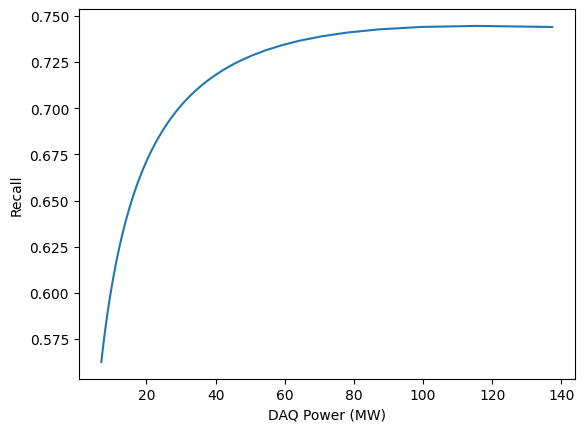

In [20]:
plt.plot(run5_metrics["power"] / 1e6, run5_metrics["recall"])
plt.ylabel("Recall")
plt.xlabel("DAQ Power (MW)")

Text(0.5, 0, 'DAQ Power (MW)')

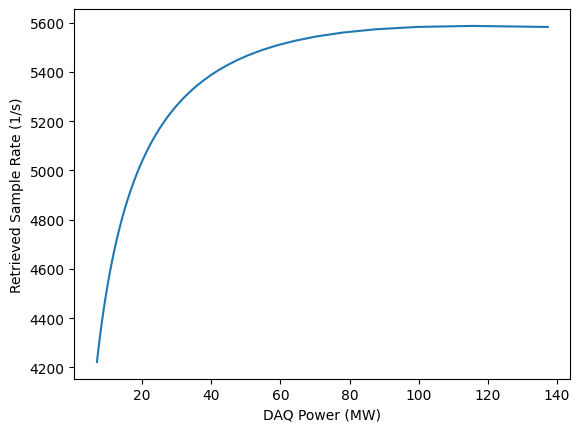

In [21]:
plt.plot(run5_metrics["power"] / 1e6, run5_metrics["productivity"])
plt.ylabel("Retrieved Sample Rate (1/s)")
plt.xlabel("DAQ Power (MW)")

In [22]:
#repeat this process for alternative configurations 
# GPU
run5_gpu_res = [vary_l1t_accept(run5_system, funcs_gpu, r) for r in l1t_reductions]
run5_gpu_metrics = extract_metrics(run5_gpu_res)

In [23]:
# Smart pixels & GPU
smartpx_system = dataframes_from_spreadsheet("cms_system_200_smartpx.xlsx")
run5_smartpx_res = [vary_l1t_accept(smartpx_system, funcs_gpu, r) for r in l1t_reductions]
run5_smartpx_metrics = extract_metrics(run5_smartpx_res)

In [24]:
# Smart pixels, GPU, & uLED
smartpx_uled_system = dataframes_from_spreadsheet("cms_system_200_smartpx_uled.xlsx")
run5_smartpx_uled_res = [vary_l1t_accept(smartpx_uled_system, funcs_gpu, r) for r in l1t_reductions]
run5_smartpx_uled_metrics = extract_metrics(run5_smartpx_uled_res)

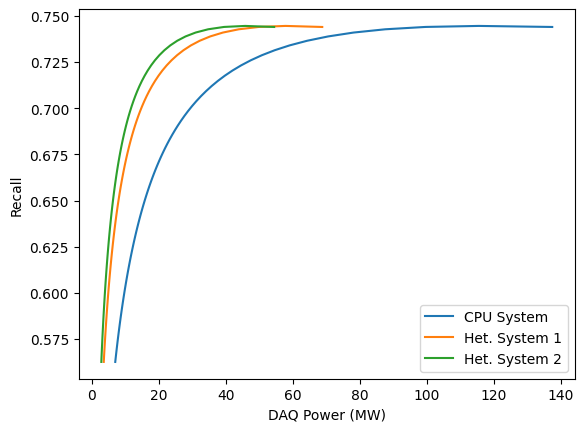

In [25]:
plt.plot(run5_metrics["power"] / 1e6, run5_metrics["recall"], label = "CPU System")
plt.plot(run5_gpu_metrics["power"] / 1e6, run5_gpu_metrics["recall"], label = "Het. System 1")
plt.plot(run5_smartpx_metrics["power"] / 1e6, run5_smartpx_metrics["recall"], label = "Het. System 2")
#plt.plot(run5_smartpx_uled_metrics["power"] / 1e6, run5_smartpx_uled_metrics["recall"], label = "Het. System 3")
plt.ylabel("Recall")
plt.xlabel("DAQ Power (MW)")
plt.legend()

In [26]:
import plotly.graph_objects as go

In [27]:
fig = go.Figure()
fig.add_scatter(x = run5_metrics["power"] / 1e6, y = run5_metrics["recall"], name="CPU")
fig.add_scatter(x = run5_gpu_metrics["power"] / 1e6, y = run5_gpu_metrics["recall"], name = "GPU")
fig.add_scatter(x = run5_smartpx_metrics["power"] / 1e6, y = run5_smartpx_metrics["recall"], name = "GPU & Smart Pixels")

fig.update_xaxes(range=(0, 60))
fig.update_layout(
    title="Recall vs. Power",
    xaxis_title="Total Power (MW)",
    yaxis_title="Recall",
    legend_title="System",
    width = 800,
    height = 600,
)


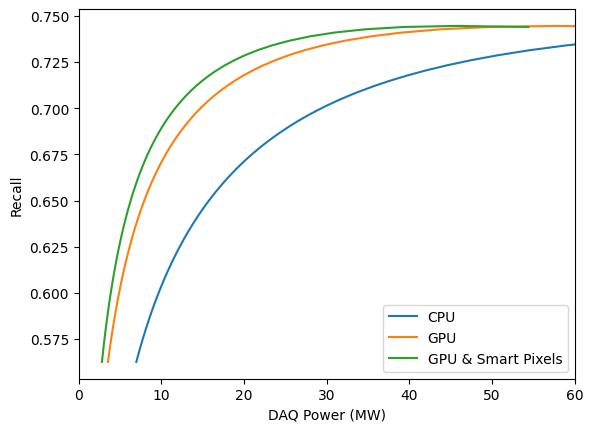

In [29]:
plt.plot(run5_metrics["power"] / 1e6, run5_metrics["recall"], label = "CPU")
plt.plot(run5_gpu_metrics["power"] / 1e6, run5_gpu_metrics["recall"], label = "GPU")
plt.plot(run5_smartpx_metrics["power"] / 1e6, run5_smartpx_metrics["recall"], label = "GPU & Smart Pixels")
#plt.plot(run5_smartpx_uled_metrics["power"] / 1e6, run5_smartpx_uled_metrics["recall"], label = "Het. System 3")
plt.ylabel("Recall")
plt.xlabel("DAQ Power (MW)")
plt.xlim(0, 60)
plt.legend()

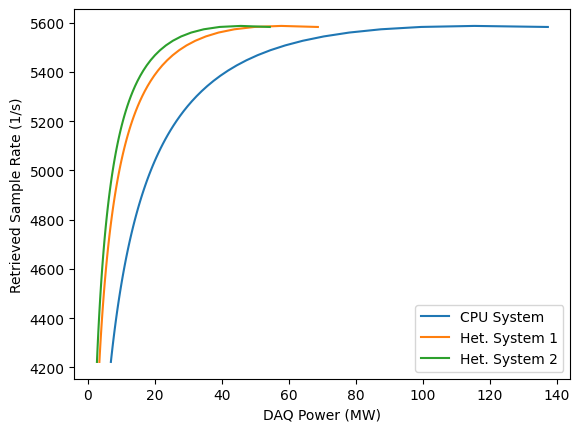

In [30]:
plt.plot(run5_metrics["power"] / 1e6, run5_metrics["productivity"], label = "CPU System")
plt.plot(run5_gpu_metrics["power"] / 1e6, run5_gpu_metrics["productivity"], label = "Het. System 1")
plt.plot(run5_smartpx_metrics["power"] / 1e6, run5_smartpx_metrics["productivity"], label = "Het. System 2")
#plt.plot(run5_smartpx_uled_metrics["power"] / 1e6, run5_smartpx_uled_metrics["recall"], label = "Het. System 3")
plt.ylabel("Retrieved Sample Rate (1/s)")
plt.xlabel("DAQ Power (MW)")
plt.legend()

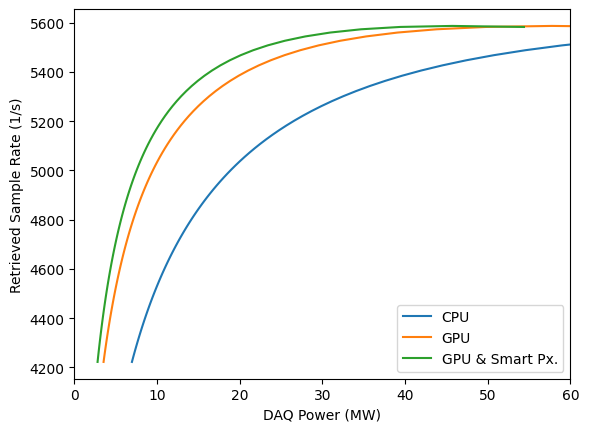

In [31]:
plt.plot(run5_metrics["power"] / 1e6, run5_metrics["productivity"], label = "CPU")
plt.plot(run5_gpu_metrics["power"] / 1e6, run5_gpu_metrics["productivity"], label = "GPU")
plt.plot(run5_smartpx_metrics["power"] / 1e6, run5_smartpx_metrics["productivity"], label = "GPU & Smart Px.")
#plt.plot(run5_smartpx_uled_metrics["power"] / 1e6, run5_smartpx_uled_metrics["recall"], label = "Het. System 3")
plt.ylabel("Retrieved Sample Rate (1/s)")
plt.xlabel("DAQ Power (MW)")
plt.xlim(0, 60)
plt.legend()